# Kenn Experiments - Plots and Statistics
Run this notebook only after all the tests have been run. Here, we will just load the results of all the tests, plot them and inspect them.

In [2]:
from model import *
from pre_elab import *
from evaluation_functions import *
import settings as s
import pickle

# Inductive Learning 

## 3 KENN layers, e2e

In [3]:
with open('results/e2e/results_inductive_100','rb') as input:
    history_inductive = pickle.load(input)

In [4]:
# plot_losses(history_100runs_inductive_3l)

In [5]:
# plot_accuracies(history_20runs_inductive_3l)

== 10% ==
Mean Test Accuracy:	NN = 0.554777; KENN = 0.593304
Test Accuracy std:	NN = 0.026296; KENN = 0.047346
			Deltas Mean = 0.038527
			Deltas Std = 0.050124

== 25% ==
Mean Test Accuracy:	NN = 0.628788; KENN = 0.672838
Test Accuracy std:	NN = 0.022025; KENN = 0.013257
			Deltas Mean = 0.044050
			Deltas Std = 0.023644

== 50% ==
Mean Test Accuracy:	NN = 0.679970; KENN = 0.715441
Test Accuracy std:	NN = 0.021550; KENN = 0.015421
			Deltas Mean = 0.035471
			Deltas Std = 0.023361

== 75% ==
Mean Test Accuracy:	NN = 0.732935; KENN = 0.753889
Test Accuracy std:	NN = 0.024611; KENN = 0.017669
			Deltas Mean = 0.020954
			Deltas Std = 0.025177

== 90% ==
Mean Test Accuracy:	NN = 0.757976; KENN = 0.766344
Test Accuracy std:	NN = 0.027193; KENN = 0.028457
			Deltas Mean = 0.008369
			Deltas Std = 0.024791



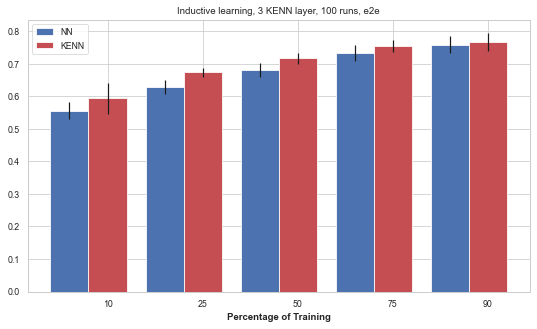

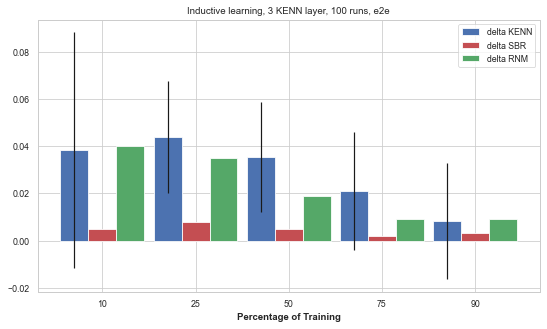

In [6]:
print_and_plot_results(
    history_inductive, 
    plot_title="Inductive learning, 3 KENN layer, 100 runs, e2e",
    other_deltas='i')

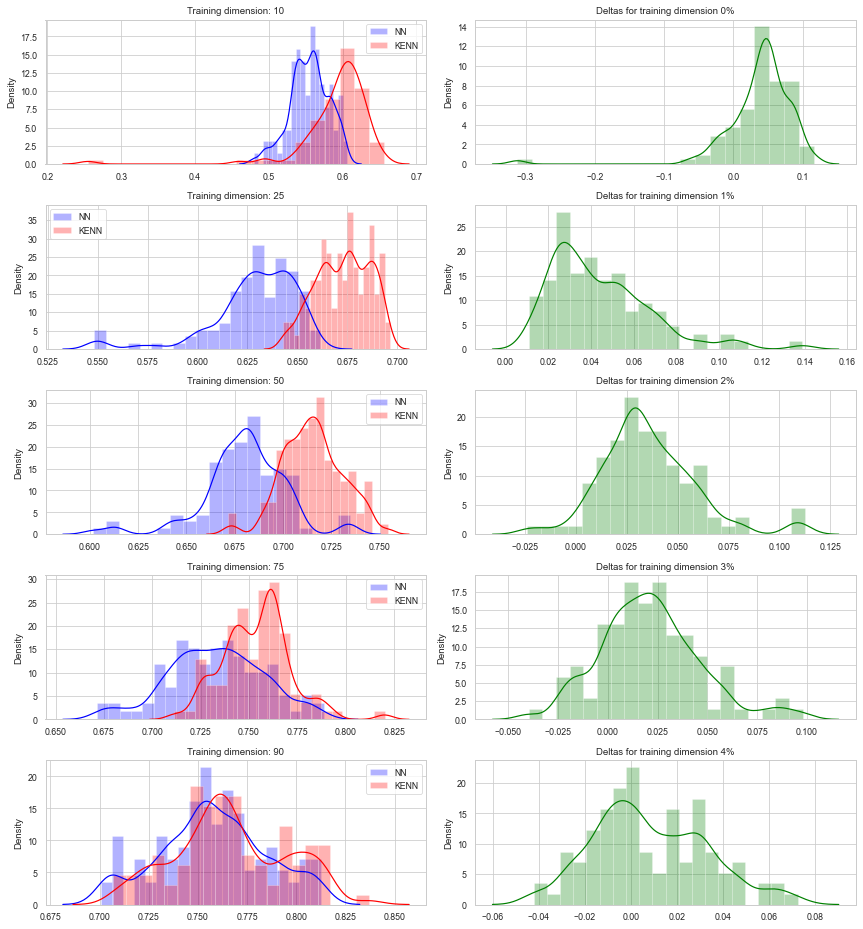

In [7]:
plot_histograms(history_inductive, bw=0.6, bins=20)

## 3 KENN layers, greedy

In [9]:
with open('results/greedy/results_inductive_100_g','rb') as input:
    history_inductive_g = pickle.load(input)

In [10]:
# plot_losses(history_20runs_inductive_3l_g)

In [11]:
# plot_accuracies(history_20runs_inductive_3l_g)

== 10% ==
Mean Test Accuracy:	NN = 0.553982; KENN = 0.567528
Test Accuracy std:	NN = 0.039106; KENN = 0.042547
			Deltas Mean = 0.013546
			Deltas Std = 0.007835

== 25% ==
Mean Test Accuracy:	NN = 0.627826; KENN = 0.636075
Test Accuracy std:	NN = 0.022876; KENN = 0.023552
			Deltas Mean = 0.008249
			Deltas Std = 0.004602

== 50% ==
Mean Test Accuracy:	NN = 0.678786; KENN = 0.684734
Test Accuracy std:	NN = 0.016973; KENN = 0.017181
			Deltas Mean = 0.005948
			Deltas Std = 0.003107

== 75% ==
Mean Test Accuracy:	NN = 0.734867; KENN = 0.737246
Test Accuracy std:	NN = 0.022802; KENN = 0.022318
			Deltas Mean = 0.002379
			Deltas Std = 0.002388

== 90% ==
Mean Test Accuracy:	NN = 0.758066; KENN = 0.759063
Test Accuracy std:	NN = 0.028622; KENN = 0.028586
			Deltas Mean = 0.000997
			Deltas Std = 0.002051



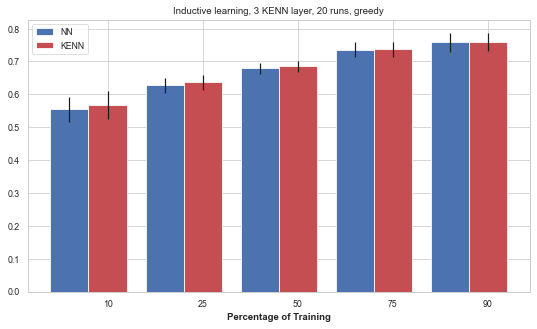

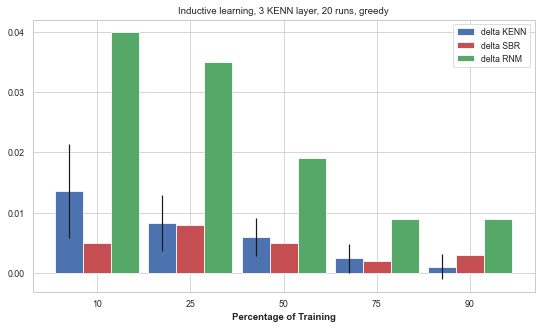

In [12]:
print_and_plot_results(
    history_inductive_g, 
    plot_title="Inductive learning, 3 KENN layer, 20 runs, greedy",
    other_deltas='i')

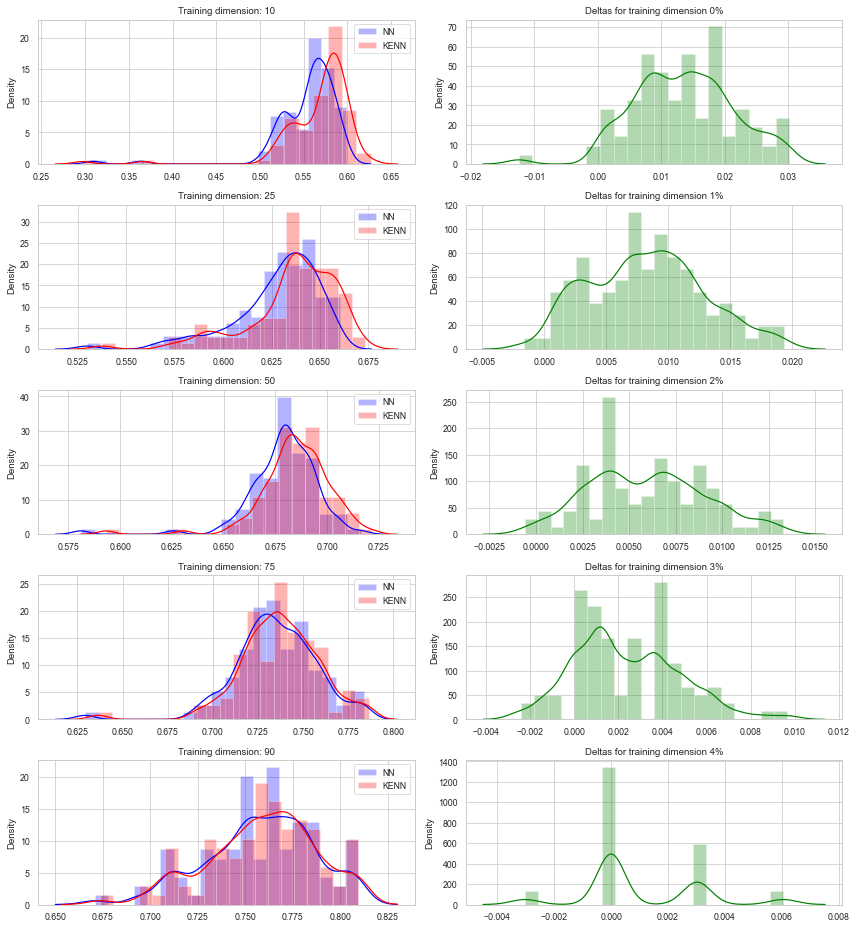

In [13]:
plot_histograms(history_inductive_g, bw=0.6, bins=20)

# Transductive Learning

## 3 KENN layers, e2e

In [14]:
with open('results/e2e/results_transductive_100','rb') as input:
    history_transductive = pickle.load(input)

In [13]:
# plot_losses(history_20runs_transductive_3l)

In [14]:
# plot_accuracies(history_20runs_transductive_3l)

== 10% ==
Mean Test Accuracy:	NN = 0.554774; KENN = 0.651020
Test Accuracy std:	NN = 0.026300; KENN = 0.020002
			Deltas Mean = 0.096246
			Deltas Std = 0.026343

== 25% ==
Mean Test Accuracy:	NN = 0.628796; KENN = 0.701087
Test Accuracy std:	NN = 0.022031; KENN = 0.013105
			Deltas Mean = 0.072291
			Deltas Std = 0.022973

== 50% ==
Mean Test Accuracy:	NN = 0.679970; KENN = 0.746165
Test Accuracy std:	NN = 0.021550; KENN = 0.012330
			Deltas Mean = 0.066196
			Deltas Std = 0.022892

== 75% ==
Mean Test Accuracy:	NN = 0.732935; KENN = 0.792150
Test Accuracy std:	NN = 0.024611; KENN = 0.015939
			Deltas Mean = 0.059215
			Deltas Std = 0.023228

== 90% ==
Mean Test Accuracy:	NN = 0.757976; KENN = 0.809154
Test Accuracy std:	NN = 0.027193; KENN = 0.025099
			Deltas Mean = 0.051178
			Deltas Std = 0.024754



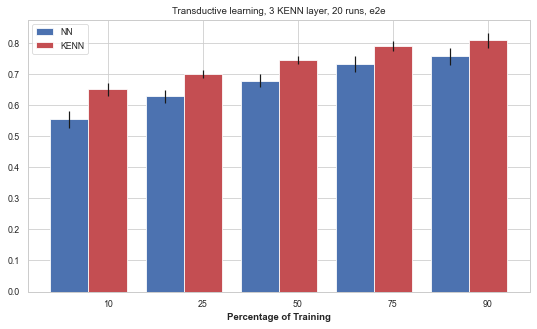

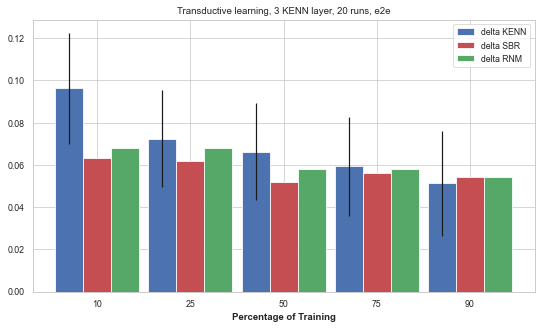

In [15]:
print_and_plot_results(
    history_transductive, 
    plot_title="Transductive learning, 3 KENN layer, 20 runs, e2e",
    other_deltas='t')

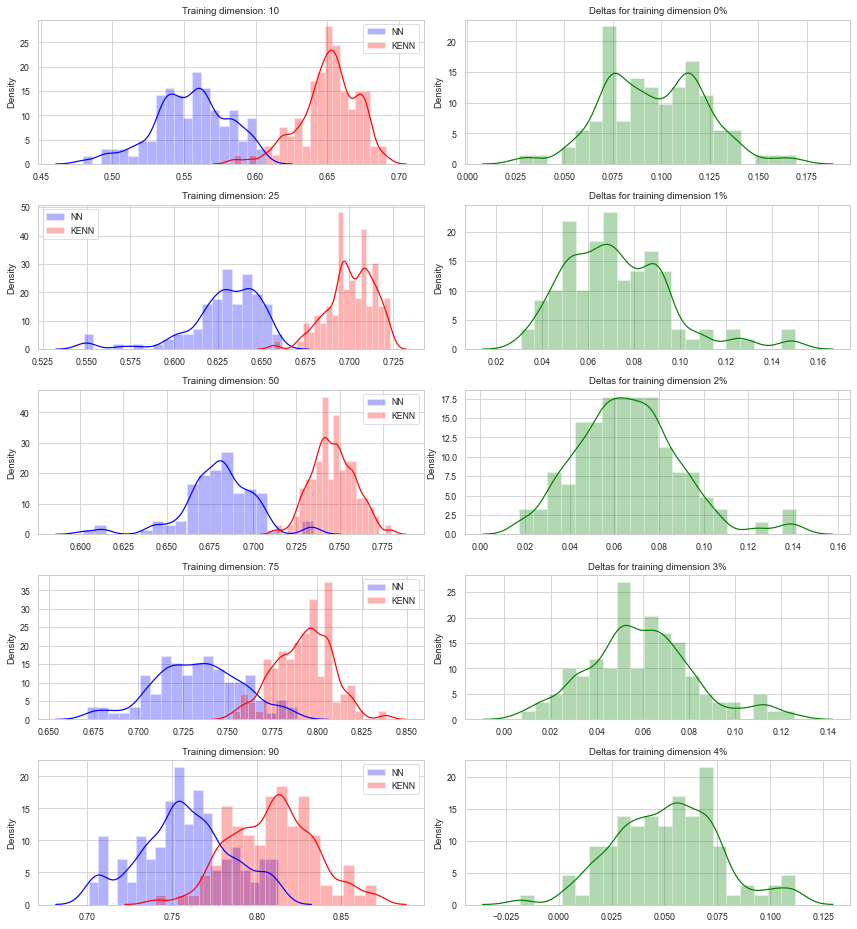

In [16]:
plot_histograms(history_transductive, bw=0.6, bins=20)

## 3 KENN layers, greedy

In [17]:
with open('results/greedy/results_transductive_100_g','rb') as input:
    history_transductive_g = pickle.load(input)

In [18]:
# plot_losses(history_20runs_transductive_3l_g)

In [19]:
# plot_accuracies(history_20runs_transductive_3l_g)

== 10% ==
Mean Test Accuracy:	NN = 0.554049; KENN = 0.569752
Test Accuracy std:	NN = 0.039098; KENN = 0.042158
			Deltas Mean = 0.015703
			Deltas Std = 0.008011

== 25% ==
Mean Test Accuracy:	NN = 0.627818; KENN = 0.639074
Test Accuracy std:	NN = 0.022864; KENN = 0.023709
			Deltas Mean = 0.011256
			Deltas Std = 0.005988

== 50% ==
Mean Test Accuracy:	NN = 0.678786; KENN = 0.689179
Test Accuracy std:	NN = 0.016973; KENN = 0.017404
			Deltas Mean = 0.010393
			Deltas Std = 0.004706

== 75% ==
Mean Test Accuracy:	NN = 0.734867; KENN = 0.742983
Test Accuracy std:	NN = 0.022802; KENN = 0.023135
			Deltas Mean = 0.008116
			Deltas Std = 0.005693

== 90% ==
Mean Test Accuracy:	NN = 0.758066; KENN = 0.765287
Test Accuracy std:	NN = 0.028622; KENN = 0.028532
			Deltas Mean = 0.007221
			Deltas Std = 0.007748



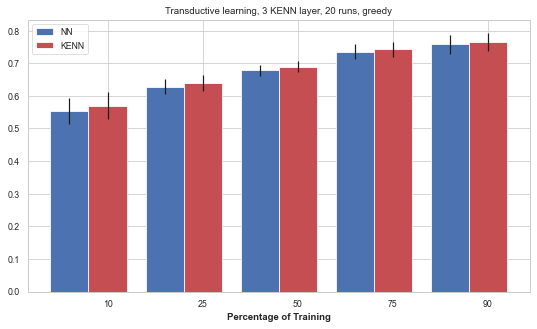

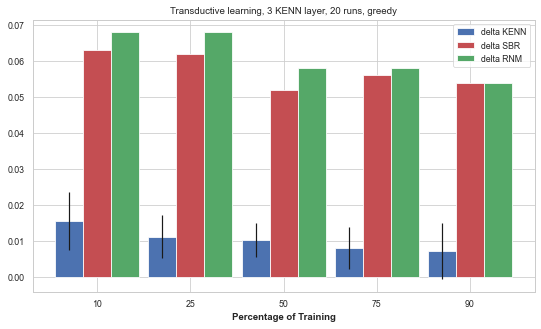

In [18]:
print_and_plot_results(
    history_transductive_g, 
    plot_title="Transductive learning, 3 KENN layer, 20 runs, greedy",
    other_deltas='t')

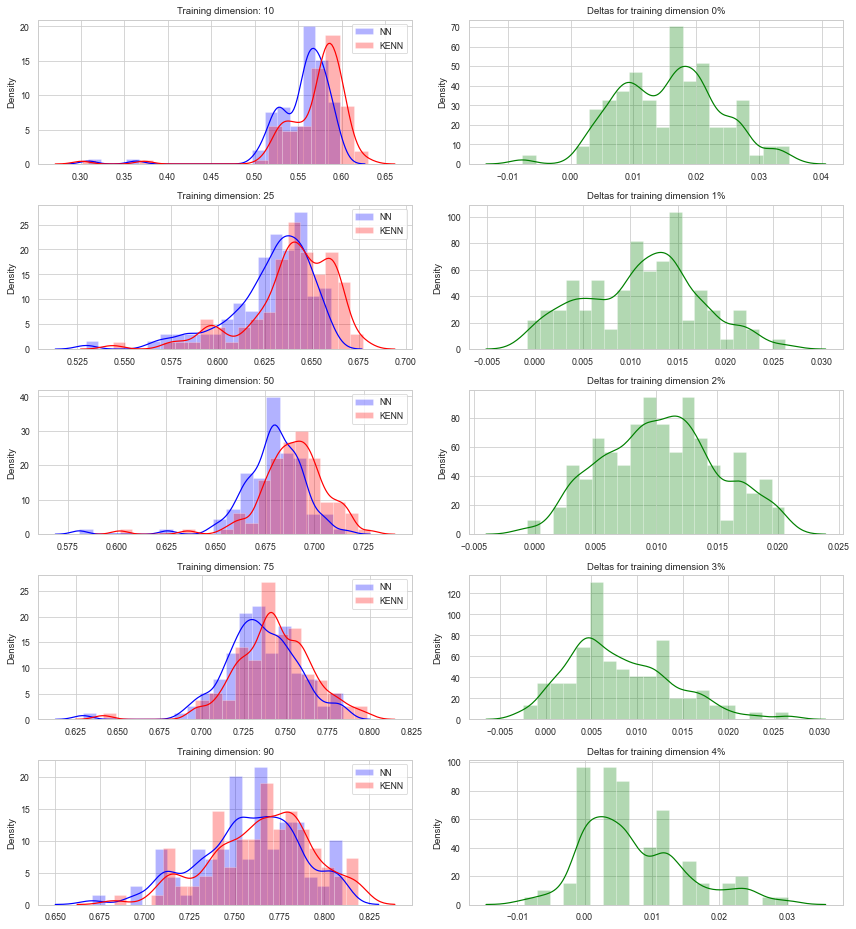

In [19]:
plot_histograms(history_transductive_g, bw=0.6, bins=20)

## Clause Weights Inspection
- Vedere se il valore dei pesi rispecchia il soddisfacimento dei vincoli nel training set
- Vedere come variano i clause weights al variare della training dimension

In [10]:
from training_inductive import train_and_evaluate_kenn_inductive
from training_transductive import train_and_evaluate_kenn_transductive
from pre_elab import generate_dataset, get_train_and_valid_lengths
from evaluation_functions import *
import matplotlib.pyplot as plt
import numpy as np
import settings as s
import tensorflow as tf

In [2]:
generate_dataset(0.9, verbose=False)

C:\Users\ricca\miniconda3\lib\site-packages\IPython\core\interactiveshell.py:3347: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [3]:
history_ind = train_and_evaluate_kenn_inductive(0.9, verbose=False)

*CB_ES* Validation Accuracy didn't increase in the last 10 epochs
*CB_ES* delta: 0.00067460537
callback_early_stopping signal received at epoch= 33/300
Terminating training 
Test Accuracy: 0.7885196208953857


In [4]:
history_tra = train_and_evaluate_kenn_transductive(0.9, verbose=False)

*CB_ES* Validation Accuracy didn't increase in the last 10 epochs
*CB_ES* delta: -0.0050590634
callback_early_stopping signal received at epoch= 43/300
Terminating training 
Test Accuracy: 0.8006042242050171


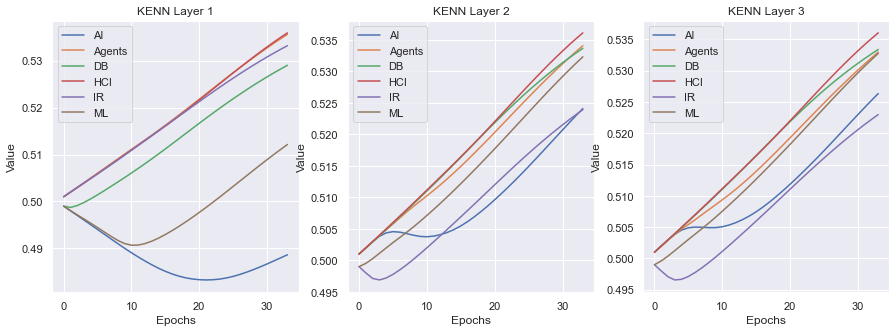

In [11]:
plot_clause_weights(history_ind)

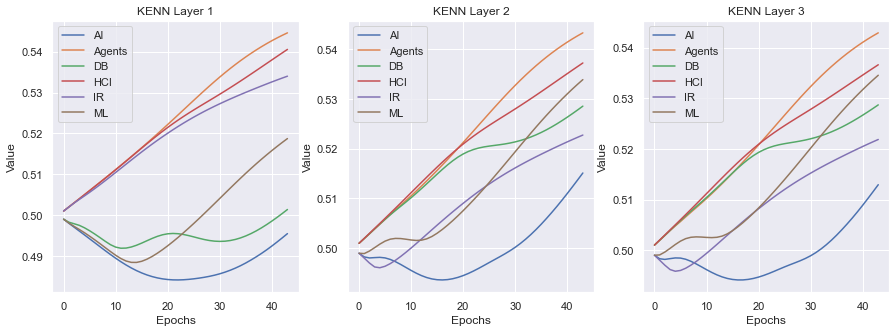

In [12]:
plot_clause_weights(history_tra)

## How much does the training set comply with out Base Knowledge?

In [18]:
id_x_train = np.load('dataset/CiteSeer/index_x_inductive_training.npy')
id_y_train = np.load('dataset/CiteSeer/index_y_inductive_training.npy')
labels = np.load('dataset/CiteSeer/labels.npy')
features = np.load('dataset/CiteSeer/features.npy')

topics = ["AI","Agents","DB","HCI","IR","ML"]

generate_dataset(0.9, verbose=False)
train_len, valid_len = get_train_and_valid_lengths(features, 0.9)
train_labels = labels[:train_len]

In [53]:
total_cited_nodes = {
    "AI":0,
    "Agents":0,
    "DB":0,
    "HCI":0,
    "IR":0,
    "ML":0
}

same_topic_cited_nodes = {
    "AI":0,
    "Agents":0,
    "DB":0,
    "HCI":0,
    "IR":0,
    "ML":0
}

verbose = False
for i in range(train_len):
    # indexes of nodes pointed by edges coming from i
    is_topic = topics[np.where(train_labels[i].squeeze()==1)[0][0]]
    pointed_by_i_indexes = np.where(id_x_train.squeeze()==i)[0].tolist()
    pointed_by_i = id_y_train.squeeze()[pointed_by_i_indexes].tolist()
    if pointed_by_i != []:
        total_cited_nodes[is_topic] +=len(pointed_by_i)
        topics_of_pointed_by_i = []
        for j in pointed_by_i:
            js_topic = topics[np.where(train_labels[j].squeeze()==1)[0][0]]
            topics_of_pointed_by_i.append(js_topic)
            if js_topic == is_topic:
                same_topic_cited_nodes[is_topic] += 1
        
        if verbose:
            print("-- Looking at index {} --".format(i))
            print("Doc. {}'s topic: {}".format(
                i,
                is_topic))

            print("Topics of documents pointed by doc. {}: {}".format(
                i,
                topics_of_pointed_by_i))

In [54]:
print(total_cited_nodes)
print(same_topic_cited_nodes)

{'AI': 255, 'Agents': 415, 'DB': 402, 'HCI': 353, 'IR': 535, 'ML': 410}
{'AI': 113, 'Agents': 315, 'DB': 287, 'HCI': 307, 'IR': 437, 'ML': 255}


In [55]:
clause_compliance = {
    'AI' : same_topic_cited_nodes['AI']/total_cited_nodes['AI'],
    'Agents' : same_topic_cited_nodes['Agents']/total_cited_nodes['Agents'],
    'DB' : same_topic_cited_nodes['DB']/total_cited_nodes['DB'],
    'HCI' : same_topic_cited_nodes['HCI']/total_cited_nodes['HCI'],
    'IR' : same_topic_cited_nodes['IR']/total_cited_nodes['IR'],
    'ML' : same_topic_cited_nodes['ML']/total_cited_nodes['ML']
}
clause_compliance

{'AI': 0.44313725490196076,
 'Agents': 0.7590361445783133,
 'DB': 0.7139303482587065,
 'HCI': 0.8696883852691218,
 'IR': 0.8168224299065421,
 'ML': 0.6219512195121951}

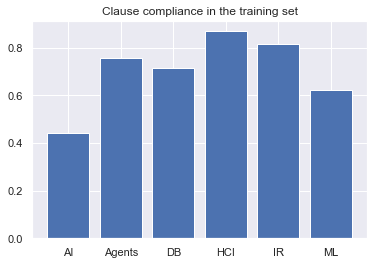

In [56]:
plt.bar(topics, list(clause_compliance.values()))
plt.title("Clause compliance in the training set")
plt.show()